In [38]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# make the original data
series = np.sin((0.1 * np.arange(400)) ** 2) 

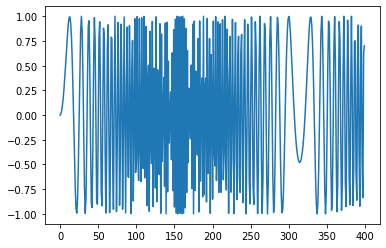

In [40]:
plt.plot(series);

In [41]:
# Build the dataset
T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:T+t]
  y = series[t]
  X.append(x)
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (390, 10, 1), Y.shape: (390, 1)


In [42]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [48]:
# Define LSTM
class GRU(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(GRU, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.GRU(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states (L x N x M)
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    # get the RNN unit output
    # out is of size (N x T x M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need these now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [49]:
# Instantiate the model
model = GRU(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

GRU(
  (rnn): GRU(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [50]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [51]:
# Shuffling would not make sense because a real forecasting model has to predict
# the future, it can't train on the points within the future.
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.5, shuffle=False)
# Checking whether train_test_split function works as expected
np.allclose(X[:N//2], Xtrain)

True

In [52]:
# Make inputs and targets / Move data to GPU
Xtrain = torch.from_numpy(Xtrain.astype(np.float32)).to(device)
Xtest = torch.from_numpy(Xtest.astype(np.float32)).to(device)
Ytrain = torch.from_numpy(Ytrain.astype(np.float32)).to(device)
Ytest = torch.from_numpy(Ytest.astype(np.float32)).to(device)

In [53]:
# Training
def full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest, epochs=200):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(Xtrain)
    loss = criterion(outputs, Ytrain)

    # Backward and Optimizer
    loss.backward()
    optimizer.step()

    train_losses[i] = loss.item()

    # Test Loss
    test_outputs = model(Xtest)
    test_loss = criterion(test_outputs, Ytest)
    test_losses[i] = test_loss.item()

    if (i+1) % 5 == 0:
      print(f"Epoch: {i+1}/{epochs}, Train Loss:{train_losses[i]:.4f}, Test Loss:{test_losses[i]:.4f}")
  
  return train_losses, test_losses

In [54]:
train_losses, test_losses = full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest)

Epoch: 5/200, Train Loss:0.5115, Test Loss:0.4748
Epoch: 10/200, Train Loss:0.5094, Test Loss:0.4603
Epoch: 15/200, Train Loss:0.4839, Test Loss:0.4244
Epoch: 20/200, Train Loss:0.3190, Test Loss:0.2242
Epoch: 25/200, Train Loss:0.0761, Test Loss:0.0408
Epoch: 30/200, Train Loss:0.0230, Test Loss:0.0150
Epoch: 35/200, Train Loss:0.0184, Test Loss:0.0117
Epoch: 40/200, Train Loss:0.0171, Test Loss:0.0090
Epoch: 45/200, Train Loss:0.0123, Test Loss:0.0121
Epoch: 50/200, Train Loss:0.0079, Test Loss:0.0067
Epoch: 55/200, Train Loss:0.0047, Test Loss:0.0068
Epoch: 60/200, Train Loss:0.0030, Test Loss:0.0030
Epoch: 65/200, Train Loss:0.0019, Test Loss:0.0030
Epoch: 70/200, Train Loss:0.0014, Test Loss:0.0013
Epoch: 75/200, Train Loss:0.0020, Test Loss:0.0032
Epoch: 80/200, Train Loss:0.0008, Test Loss:0.0016
Epoch: 85/200, Train Loss:0.0010, Test Loss:0.0013
Epoch: 90/200, Train Loss:0.0008, Test Loss:0.0005
Epoch: 95/200, Train Loss:0.0003, Test Loss:0.0003
Epoch: 100/200, Train Loss:0.000

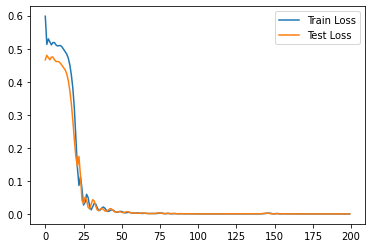

In [55]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [56]:
# "Wrong" forecast using true targets
predictions = []

# index of the first validation input
i = 0

while len(predictions) < len(Ytest):
  input_ = Xtest[i].reshape(1, T, 1)
  p = model(input_)[0, 0].item()
  i += 1

  # update the predictions list
  predictions.append(p)

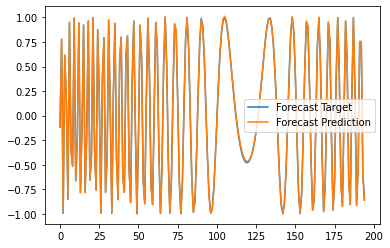

In [57]:
plt.plot(Ytest.cpu().numpy(), label='Forecast Target')
plt.plot(predictions, label='Forecast Prediction')
plt.legend();

In [58]:
# Forecast Future Values (use only self-predictions for making future predictions)
predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2])
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = Xtest[0].view(T)

while len(predictions) < len(Ytest):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0, 0] -> 1 x 1 array -> scalar

  predictions.append(p[0, 0].item())

  # make the new input 
  last_x = torch.cat((last_x[1:], p[0]))

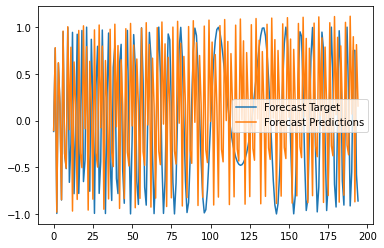

In [59]:
plt.plot(Ytest.cpu().numpy(), label='Forecast Target')
plt.plot(predictions, label="Forecast Predictions")
plt.legend();